# Run model with just SEI, Li+ concentration in the electrolyte eventually increases as porosity decrease. As some point, the large c(Li+) will fail all polynomial forms of electrolyte property (diffusivity and conductivity and give wrong results). If we take the form of exponential, that can ensure low diffusivity and conductivity, but that seems to cause some numerical problems.

In [51]:
# import modules
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import traceback
import imageio.v2 as imageio


In [52]:
font = {'family' : 'DejaVu Sans',
        #'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)

In [53]:
# import function 
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2_Crack_simp import (
    GetScan,
    recursive_scan,
    GetSol_dict,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,
    Get_initial_cap,
    Get_initial_cap2,
    Plot_Loc_Var_sol
)

Para_0.search('mole')

In [54]:
from numpy import exp,sqrt
def electrolyte_diffusivity_Nyman2008Exp(c_e,c_EC, T):
    D_c_e = (
        6 * exp( -1 *(c_e/1000)) 
        * exp(-5/298.15) 
        * exp(-95/298.15*(c_e/1000)) * 1e-10 
    )
    return D_c_e

def electrolyte_conductivity_Nyman2008Exp(c_e,c_EC, T):
    sigma_e = (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) 
    )
    return sigma_e
print(electrolyte_diffusivity_Nyman2008Exp(10,4541, 298.15))
print(electrolyte_conductivity_Nyman2008Exp(10,4541, 298.15))

5.822927088266968e-10
0.03803688841420761


In [55]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R5/'; 
Target  = 'High_c(Li+)_Nyman2008Exp/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [56]:
# set-up and run model
V_max = 4.2;        V_min = 2.5;
total_cycle = 1; save_at_cycles= 1
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V (1 minutes period)" ,     )] * total_cycle ) 
Elely = ["lipf6_Nyman2008Exp","lipf6_Nyman2008"]
Sim = [];Sol=[]; 
for elely in Elely:
    ChemistryChen=pybamm.parameter_sets.Chen2020 
    ChemistryChen["electrolyte"] = elely
    Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
    Para_0['Negative electrode porosity'] =  0.1
    #print(Model_d.options["solvent diffusion"])
    Para_0['Ratio of lithium moles to SEI moles'] =  1
    model = pybamm.lithium_ion.DFN()
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    model.variables["Electrolyte diffusivity [m2.s-1]"] =(
        Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))
    var = pybamm.standard_spatial_vars  
    mesh_thick = 100; mesh_par=30;
    var_pts = {
        var.x_n: int(mesh_thick),  
        var.x_s: int(20),  
        var.x_p: int(mesh_thick),  
        var.r_n: int(mesh_par),  
        var.r_p: int(mesh_par),  }  
    sim = pybamm.Simulation(
        model, experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),
        var_pts=var_pts,)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
        print(sol.cycles[-1].steps[-1]);  # a way to check whether the solution is finalized 
    except:
        print('Fail for electrolyte: ',elely)
    else:
        Sol.append(sol)   
        print('Succeed for electrolyte: ',elely)

Succeed for electrolyte:  lipf6_Nyman2008Exp
Succeed for electrolyte:  lipf6_Nyman2008


In [57]:
print(len(Sol[0]["Electrolyte conductivity [S.m-1]"].entries[0,:] ))

26


In [58]:
print(Sol[0]["Electrolyte conductivity [S.m-1]"].entries [:,6] )

[0.12310918 0.12306233 0.12296861 0.12282806 0.12264071 0.12240668
 0.12212609 0.12179914 0.12142609 0.12100728 0.12054315 0.12003429
 0.11948146 0.11888566 0.1182482  0.11757082 0.11685584 0.11610639
 0.11532674 0.11452281 0.11370293 0.11287905 0.11206869 0.11129809
 0.11060741 0.11005925 0.10975235 0.10984163 0.11056204 0.11224089
 0.11526204 0.1199455  0.12638323 0.13437926 0.14356998 0.15359772
 0.16419988 0.1752136  0.18654932 0.19816439 0.21004458 0.22219249
 0.23462075 0.2473479  0.2603961  0.2737896  0.2875539  0.30171511
 0.31629953 0.33133321 0.34684165 0.3628493  0.37937919 0.39645235
 0.41408719 0.4322988  0.45109808 0.47049081 0.49047659 0.51104765
 0.53218759 0.55387002 0.57605723 0.5986988  0.62173039 0.64507258
 0.6686301  0.69229132 0.71592829 0.7393973  0.7625402  0.78518635
 0.8071554  0.82826078 0.84831381 0.86712834 0.88452561 0.90033915
 0.91441936 0.92663759 0.93688927 0.94509608 0.95120692 0.95519759
 0.9570694  0.95684662 0.9545732  0.95030882 0.94412477 0.9360

In [59]:
print(Sol[0]["Electrolyte concentration [mol.m-3]"].entries[:,21] )
print(Sol[0]["Electrolyte conductivity [S.m-1]"].entries[:,21] )
#print(Sol[0]["Electrolyte diffusivity [m2.s-1]"].entries[:,10])

[10486.70973757 10493.4275772  10506.9570613  10527.38503704
 10554.8355671  10589.47575831 10631.51913356 10681.22933992
 10738.9246868  10804.98374499 10879.85222372 10964.05138199
 11058.18829587 11162.96838958 11279.21075057 11407.86689162
 11550.04380197 11707.03234459 11880.34229003 12071.745463
 12283.32841078 12517.55510528 12777.33684585 13066.09613523
 13387.78007939 13746.67991116 14146.51987246 14585.29239336
 14969.02476553  2954.86096597  2942.66439499  2918.3277295
  2882.78507312  2837.40798102  2783.81279576  2723.68954103
  2658.68000731  2590.3019699   2519.91009667  2448.67623763
  2377.57323002  2307.3623289   2238.59579626  2171.63921376
  2106.70636606  2043.89653364  1983.22755579  1924.66221709
  1868.12802968  1813.53148775  1760.76805332  1709.72898385
  1660.30587887  1612.39360272  1565.89206423  1520.70720029
  1476.75141361  1433.94364415  1392.20920269  1351.47945804
  1311.69144184  1272.78741534  1234.71442787  1197.42388647
  1160.87114871  1125.01514

In [60]:
label = [elely for elely in Elely]
output_variables3 = [
    "Terminal voltage [V]",   
    "Electrolyte potential [V]",
    "Electrolyte concentration [mol.m-3]",
    "Li+ flux [mol.m-2.s-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]"
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='minutes',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
#quick_plot.create_gif(
#    number_of_images=30, duration=4,output_filename=BasicPath + Target+"All_figures.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=58.89045942719522, step=0.5889045942719522),…

In [61]:
output_variables3 = [
    "Terminal voltage [V]",   
    "Electrolyte potential [V]",
    "Electrolyte concentration [mol.m-3]",
    "Li+ flux [mol.m-2.s-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]"
]
quick_plot = pybamm.QuickPlot(
    Sol[0], 
    output_variables3,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"concentration and flux.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=0.4137838421694915, step=0.00413783842169491…

(<Figure size 1512x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Electrolyte concentration [mol.m-3]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Electrolyte potential [V]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Porosity'}, xlabel='x [m]'>],
       dtype=object))

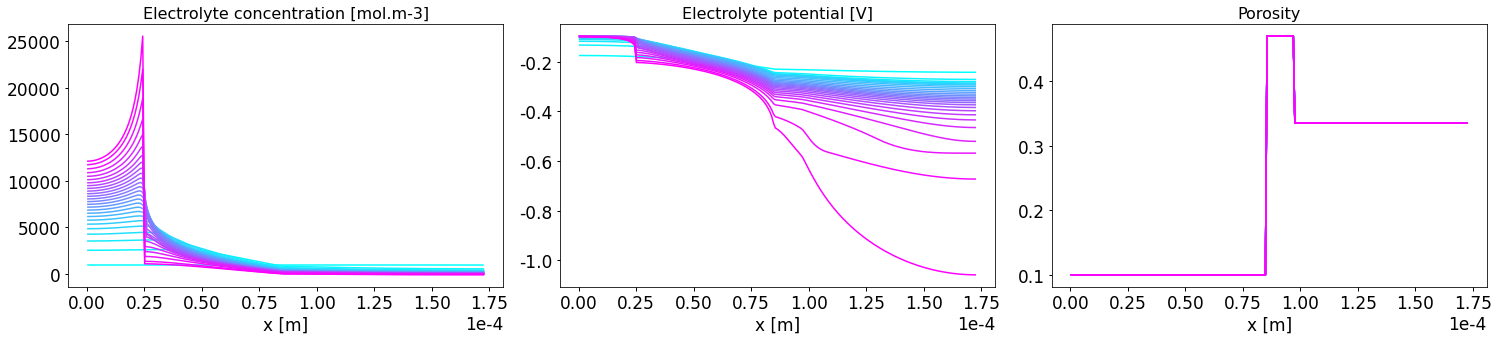

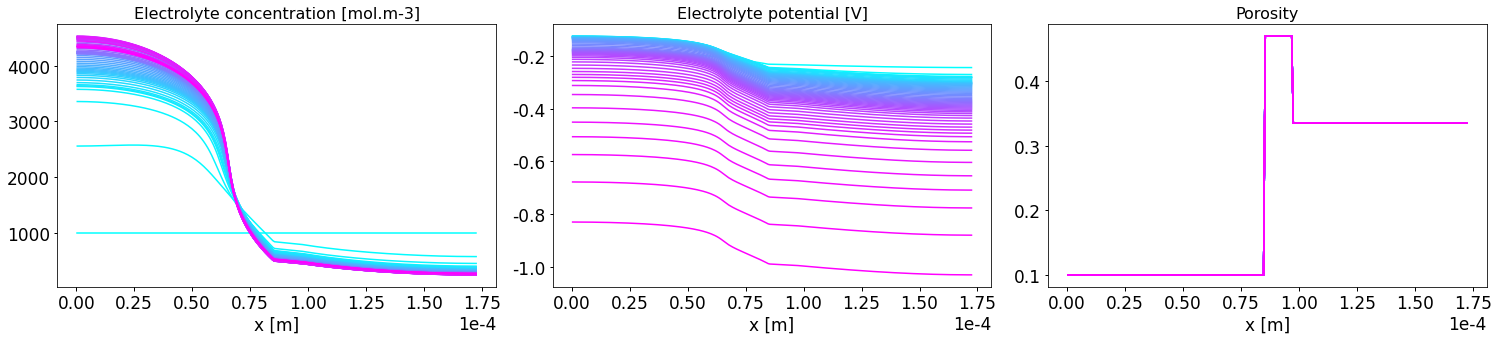

In [62]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,0,'cool')

(<Figure size 1008x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Electrolyte diffusivity [m2.s-1]'}, xlabel='x [m]'>,
        <AxesSubplot:title={'center':'Electrolyte conductivity [S.m-1]'}, xlabel='x [m]'>],
       dtype=object))

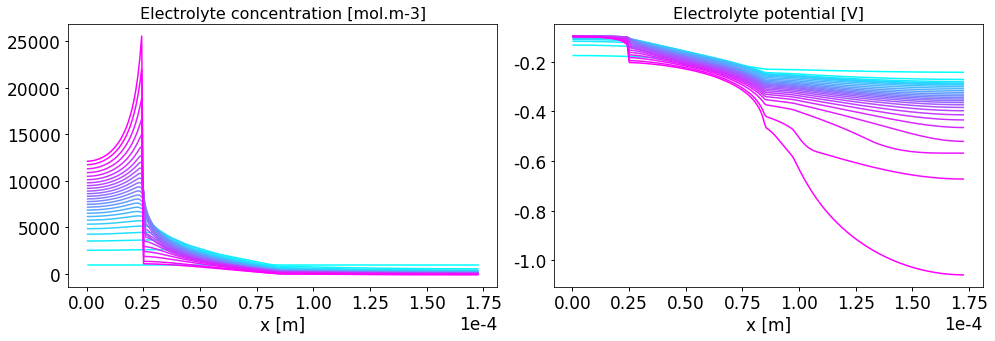

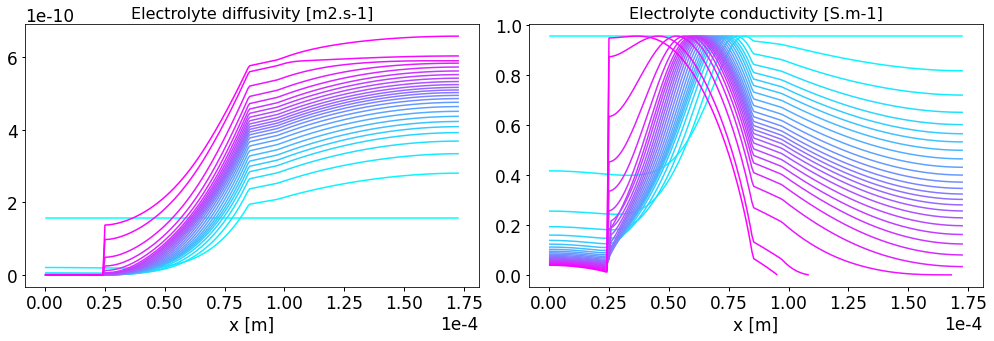

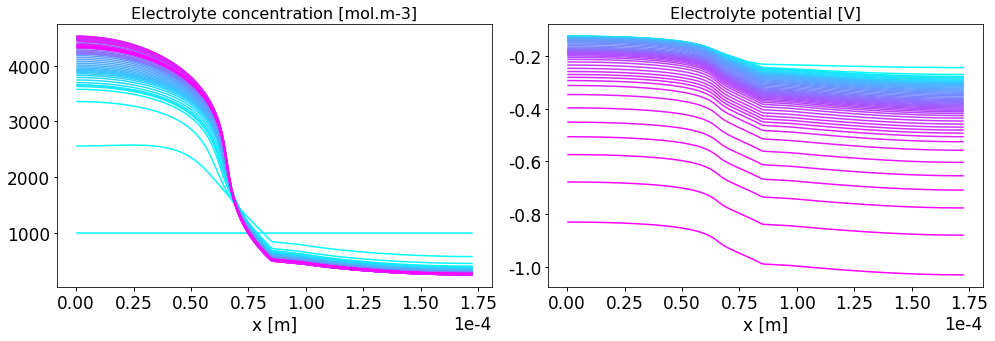

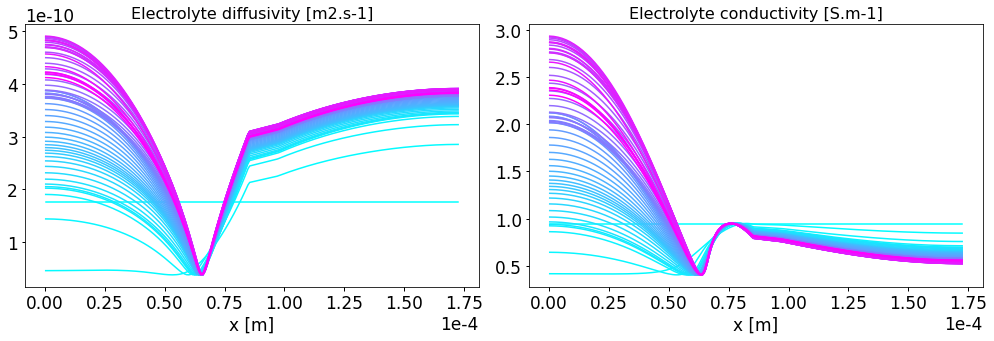

In [63]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]",], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]",], 
    ["Electrolyte diffusivity [m2.s-1]","Electrolyte conductivity [S.m-1]"], 
    0,0,'cool')


Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]",], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"], 
    0,0,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]",], 
    ["Electrolyte diffusivity [m2.s-1]","Electrolyte conductivity [S.m-1]"], 
    0,0,'cool')

IndexError: list index out of range

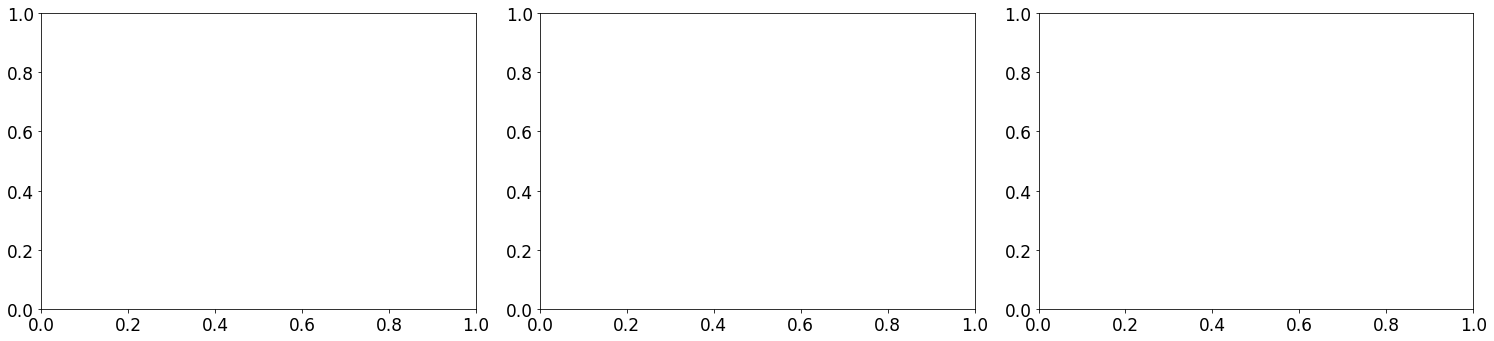

In [64]:
Plot_Loc_Var_sol(
    Sol[0],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,1,'cool')
Plot_Loc_Var_sol(
    Sol[1],
    ["x [m]","x [m]","x [m]"], 
    ["Electrolyte concentration [mol.m-3]","Electrolyte potential [V]","Porosity",], 
    0,1,'cool')